In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model.logistic import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [2]:
# Read file
path = '/Users/rodrigovillatoro/Documents/Harbour.Space/07_ml_1/data/ConfLongDemo_JSI.txt'
names = ['name', 'tag', 'timestamp', 'date', 'x', 'y', 'z', 'activity']
date_parser = lambda x: pd.datetime.strptime(x, '%d.%m.%Y %H:%M:%S:%f')
df = pd.read_csv(path, names=names, header=None, parse_dates=[3], date_parser=date_parser)

In [3]:
df.head()

,name,tag,timestamp,date,x,y,z,activity
0,A01,010-000-024-033,633790226051280329,2009-05-27 14:03:25.127,4.062931,1.892434,0.507425,walking
1,A01,020-000-033-111,633790226051820913,2009-05-27 14:03:25.183,4.291954,1.781140,1.344495,walking
2,A01,020-000-032-221,633790226052091205,2009-05-27 14:03:25.210,4.359101,1.826456,0.968821,walking
3,A01,010-000-024-033,633790226052361498,2009-05-27 14:03:25.237,4.087835,1.879999,0.466983,walking
4,A01,010-000-030-096,633790226052631792,2009-05-27 14:03:25.263,4.324462,2.072460,0.488065,walking


In [4]:
names = df['name'].unique()
tags = df['tag'].unique()

In [5]:
df = df.sort_values(by=['name', 'tag', 'date'])

In [6]:
df.shape

(164860, 8)

## Some exploratory analysis

In [7]:
a01 = df[df['name'] == 'A01']
a01 = a01[a01['tag'] == '010-000-024-033']

In [8]:
a01.shape

(1672, 8)

In [9]:
a01['dx'] = a01['x'].diff(1)

In [10]:
a01.head()

,name,tag,timestamp,date,x,y,z,activity,dx
0,A01,010-000-024-033,633790226051280329,2009-05-27 14:03:25.127,4.062931,1.892434,0.507425,walking,NaN
3,A01,010-000-024-033,633790226052361498,2009-05-27 14:03:25.237,4.087835,1.879999,0.466983,walking,0.024904
7,A01,010-000-024-033,633790226053442677,2009-05-27 14:03:25.343,3.958496,1.703563,0.511041,walking,-0.129339
9,A01,010-000-024-033,633790226054523854,2009-05-27 14:03:25.453,4.016991,1.734065,0.193167,walking,0.058495
13,A01,010-000-024-033,633790226055605037,2009-05-27 14:03:25.560,3.748375,2.073422,0.254482,walking,-0.268616


In [11]:
time_delta = a01['date'].diff(1)

In [12]:
time_delta.dtype

dtype('<m8[ns]')

In [13]:
time_delta[1:].values

array([110000000, 106000000, 110000000, ..., 106000000, 110000000,
       107000000], dtype='timedelta64[ns]')

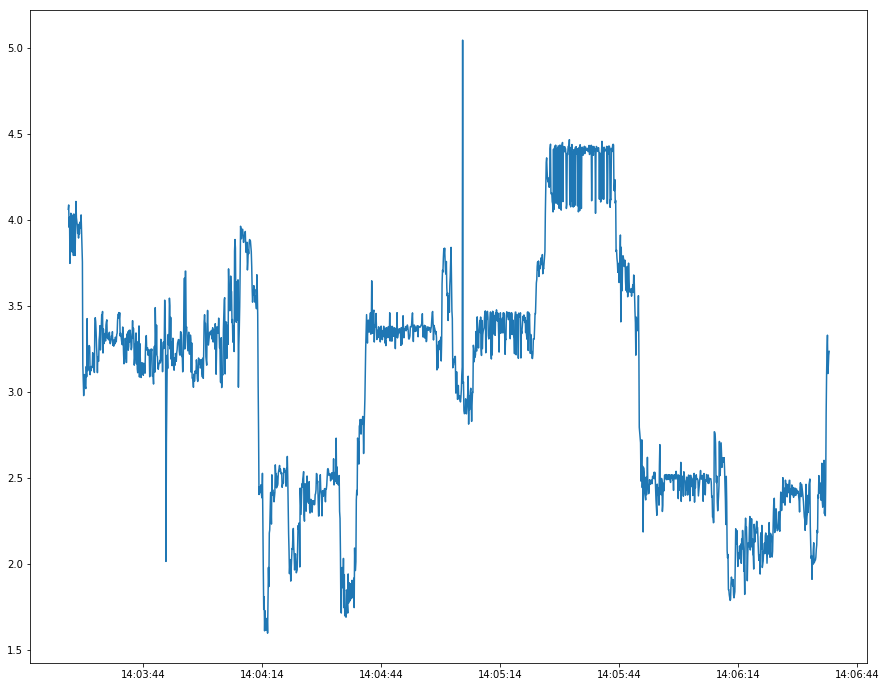

In [14]:
plt.figure(figsize=(15, 12))
plt.plot(a01['date'], a01['x'])
plt.show()

## Calculate the change in X, Y, Z coordinates for each person

In [15]:
data_frames = []
for name in names:
    temp_df1 = df[df['name'] == name].copy()
    for tag in tags:
        temp_df2 = temp_df1[temp_df1['tag'] == tag].copy()
        time_delta = temp_df2['date'].diff(1)
        temp_df2['dx'] = temp_df2['x'].diff(1)
        temp_df2['dy'] = temp_df2['y'].diff(1)
        temp_df2['dz'] = temp_df2['z'].diff(1)
        data_frames.append(temp_df2)

In [16]:
# Concatenate the all the data_frames and drop NA's
new_df = pd.concat(data_frames)
new_df = new_df.dropna()

In [17]:
new_df.shape

(164760, 11)

In [18]:
tags = pd.get_dummies(df['tag'], prefix='tag')
names = pd.get_dummies(df['name'], prefix='name')

In [19]:
new_df = new_df.join([tags, names])

In [20]:
new_df.shape

(164760, 40)

## Drop Columns that will not be used in the classification

In [21]:
y = new_df['activity']
y = y.astype('category').cat.codes

In [22]:
X = new_df.drop(['activity', 'date', 'timestamp', 'tag', 'name'], axis=1)

In [23]:
X.columns

Index(['x', 'y', 'z', 'dx', 'dy', 'dz', 'tag_010-000-024-033',
       'tag_010-000-030-096', 'tag_020-000-032-221', 'tag_020-000-033-111',
       'name_A01', 'name_A02', 'name_A03', 'name_A04', 'name_A05', 'name_B01',
       'name_B02', 'name_B03', 'name_B04', 'name_B05', 'name_C01', 'name_C02',
       'name_C03', 'name_C04', 'name_C05', 'name_D01', 'name_D02', 'name_D03',
       'name_D04', 'name_D05', 'name_E01', 'name_E02', 'name_E03', 'name_E04',
       'name_E05'],
      dtype='object')

In [24]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Train Logistic Regression

In [25]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

In [26]:
clf.score(X_test, y_test)

0.40706482155863072

Confussion Matrix:
[[    0   403     0     0   175     0     5     0     0     0   184]
 [    0 11021     0   210   929     0   204     0     0     0  1272]
 [    0  1101     1    24    20     0     0     0     0     0   416]
 [    0   874     0   197    43     0     0     0     0     0   159]
 [    0  3062     0     8  1303     0     2     0     0     0  2372]
 [    0   294     0     1    36     0     0     0     0     0   127]
 [    0  2289     0     1   375     0   303     0     0     0    72]
 [    0  3359     1    91   210     0    42     0     0     0   830]
 [    0   239     0     0     9     0     0     0     0     0    78]
 [    0   657     0     0    20     0     1     0     0     0    32]
 [    0  3773     0    75   342     0     6     0     0     0  3942]]


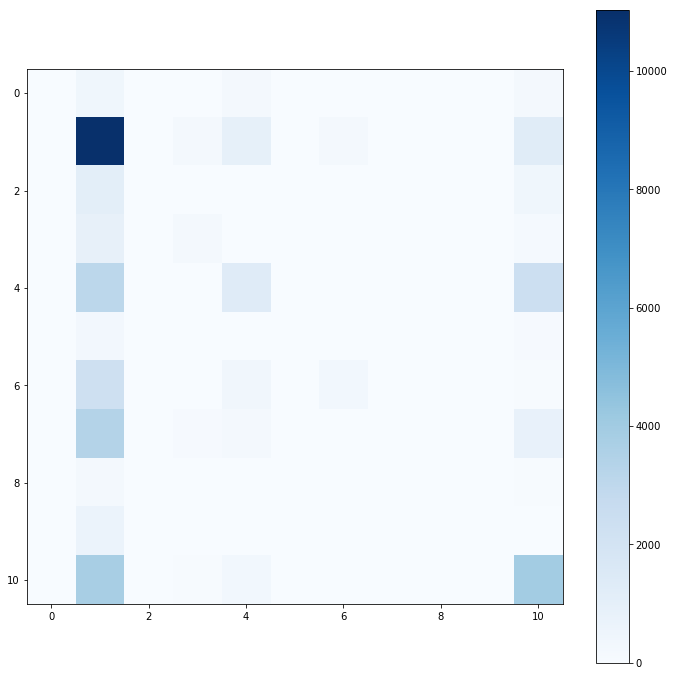

In [27]:
cm = confusion_matrix(y_test, predictions)
print('Confussion Matrix:')
print(cm)
plt.figure(figsize=(12,12))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.show()

## GaussianNB

In [28]:
clf = GaussianNB()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
clf.score(X_test, y_test)

0.18407380432143725